# Statistical Inference of Cosmological Models


The structures in universe can show a huge difference under different cosmological models.

<img src="CLUES_CDM_WDM.jpg" width="70%">

To simulate the structures in our universe, it requires **thousands of parameters**.<br>
But in most of time, only **a dozen of features** can be collected in astronomical observations.

Here, **Bayesian statistics** plays a powerful role to recover the posterior probability of complex cosmological models from a small set of constraint features and provides insights on which model best described our universe.


## Bayesian Framework 

In Bayesian statistics, the **posterior probability** is the probability of a model $M(\theta)$ given a set of random events $X$.

$P(\theta~|~X) = \frac{P(X|\theta)P(\theta)}{P(X)}$,

where $P(X~|~\theta)$ is the likelihood of the data $X$ occur under the model parameter $\theta$ <br>
(*What is the chance we obtain this set of data if the model is true?*)

$P(\theta)$ is the prior knowledge of the model<br>
(*To predict the number of incoming customer as a function of time? Excluding the weekly off-days and considering the length of working hours are the prior knowledge of model*)

$P(X)$ is the prior knowledge of the data<br>
(*In a rating system, the distribution of how many rating each user provides is the prior knowledge of data*)

Therefore, one can obtain the posterior probability by coputing the **likelihood function**.

The dimension of parameter space for the likelihood function is $DoF~ of~ model~ M(\theta)~  \times ~ num ~of~ features~ of~ data~ X$.

In this case of investigating cosmological models, I am going to explore the parameter space with over thousands of degrees of freedom. This requires a technique called **Monte-Carlo method**.


## Monte-Carlo Method

The Monte-Carlo method ramdomly selects points in the high-dimensional parameter space.<br>
If the number of points is sufficiently large, the likelihood distribution in the parameter space can be recovered.

The following code demonstrates two examples of structures in universe from my Monte-Carlo simulation:

### Calculate structure abundance ###
### Simulate structure properties ###
### Visualize simulations ###


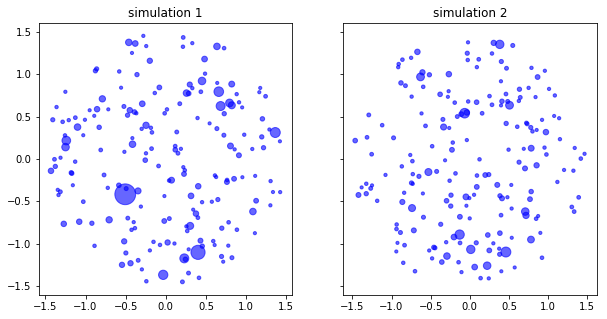

In [37]:
import numpy as np
import sub_tool as st

### Setting cosmological parameter ###
Re_arc = 0.75 
kap_tot= 3.6 
ml, mh = 6,9 
f_low,f_hi = 0.,2.
f_sub,m_c = 0.01,0. 
sigC = 4.9e10
Re = 0.0034
z_l,z_s = 0.34,3.62
### ---------------------- ###

light_cone = [z_l,z_s,Re,f_low,f_hi]
print('### Calculate structure abundance ###')
m_sub,prob_sub,Mtot,Nsub = st.sub_pdf(ml,mh,f_sub,kap_tot,m_c,light_cone,Re_arc,sigC)
submf_out = [m_sub,prob_sub,Mtot,Nsub]

print('### Simulate structure properties ###')

M_list,X_list,Y_list = [],[],[]
for i in range(2):
    M,X,Y,rvir,c = st.create_subs(submf_out,light_cone,Re_arc)
    M_list.append(M)
    X_list.append(X)
    Y_list.append(Y)

### ---------------------- ###
    
import matplotlib.pyplot as plt
import matplotlib.patches as patches
print('### Visualize simulations ###')

plt.clf()
fig, axs = plt.subplots(1,2, figsize=(10, 5), sharey=True)
axs[0].scatter(X_list[0],Y_list[0],marker='o',color='b',alpha=0.6,s=M_list[0]/1e5)
axs[1].scatter(X_list[1],Y_list[1],marker='o',color='b',alpha=0.6,s=M_list[1]/1e5)
axs[0].set_title('simulation 1')
axs[1].set_title('simulation 2')

plt.show()

## Map-reduce

The Monte-Carlo method requires heavy but repetitive calculation. <br>
Therefore, the whole calculation can be map-reduced to multiple cores for parallel computing.

Here is an example shell script to map-reduce the most heavy computing phase on a CPU-cluster:

In [ ]:
import os
import numpy as np

idx_list = np.arange(0,30) # num of jobs on each grid point
midx=10 # id of observed galaxy

f_sub_list = np.array([0.003,0.004,0.006,0.01,0.015])
filename_list = np.array(['003','004','006','01','015'])
jobname_list = np.array(['3','4','6','1','15'])
mh=3.55e7
mh_s = '70'

### sending jobs to cluster ###
for idx in idx_list:
        for i in range(len(f_sub_list)):
                f_sub,filename,jobname = f_sub_list[i],filename_list[i],jobname_list[i]
                filename = filename+mh_s
                submit_file = open('submit_loop','w')
                submit_file.write('#!/bin/bash -l\n\n')
                submit_file.write('#SBATCH --job-name=L'+str(midx)+jobname+str(idx)+'\n')
                submit_file.write('#SBATCH --time=48:00:00\n')
                submit_file.write('#SBATCH --nodes=1\n')
                submit_file.write('#SBATCH --cpus-per-task=8')
                submit_file.write('#SBATCH --mem-per-cpu=2000\n')
                submit_file.write('#SBATCH --cpus-per-task=8')
                submit_file.write('#SBATCH --mem-per-cpu=2000\n')
                submit_file.write('#SBATCH --ntasks=1\n\n')
                submit_file.write('srun python qs_pylens_mcrun_es.py '+str(midx)+' '+str(idx)+' '+str(f_sub)+' '+str(mh)+' '+filename)
                submit_file.close()

                os.system('sbatch submit_loop')

### ----------------------- ###

## Joint Analysis

After colloecting millions of simulations with Monte-Carlo method, I obtain the posterior probability of individual galaxy sample.<br>
Now the final step is to compute the joint probability curve and conclude which cosmological model best describe the observational data. 

Bayes factor between best-fit WDM model vs CDM: 4.85976516675


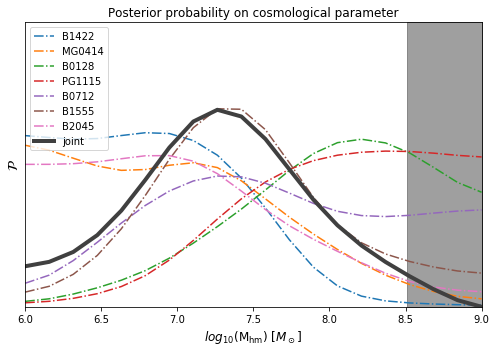

In [76]:
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter

# galaxy namelist
lens_list = np.array(['B1422','MG0414','B0128','PG1115','B0712','B1555','B2045']) 
# cosmological parameters
mass = np.array([6.0,6.75,6.9,7.35,7.4,7.55,7.75,8.2,8.5,8.8,9.0])
f_sub = np.array([0.003,0.004,0.006,0.01,0.015])
f_sub = np.log10(f_sub)

# gaussian
def gaus(x,a,x0,sigma):
	return a*np.exp(-(x-x0)**2/(2*sigma**2))

# normalization

def norm(data,x):
    data = data - np.average(data)
    d = np.max(data)-np.min(data)
    data = data/d
    data = data-np.min(data)
    data_norm = data/np.trapz(data,x)
    
    return data_norm

### plot probability curves of galaxies ###

mass_int = np.linspace(min(mass),max(mass),20)
fsub_int = np.linspace(min(f_sub),max(f_sub),10)

# combine pdf
pdf_com = np.zeros((len(lens_list),20))
pdf_com.fill(1.0)

i = 0
plt.clf()
plt.figure(figsize=(7,5))
for lens in lens_list:
    pdf_file = lens+'_wdm_n3.txt'
    like_table = np.loadtxt(pdf_file)#[:,1:]
    like_table = np.transpose(like_table)

    f = interpolate.interp2d(f_sub,mass,like_table)
    pdf = f(fsub_int,mass_int)
    curve_pdf = np.max(pdf,axis=1)

    ## normalization
    curve_pdf = norm(curve_pdf,mass_int)
    
    ## smooth
    curve_pdf =gaussian_filter(curve_pdf,2)
    pdf_com[i,:] =curve_pdf

    ## plot
    plt.plot(mass_int,pdf_com[i,:],linestyle='-.',label=lens)

    i = i+1
    
### ------------------------------ ###

### combine posterior probability ###

curve_array = np.sum(pdf_com,axis=0)
curve_array = norm(curve_array,mass_int)

## gaussian fitting
fit_param, covar = curve_fit(gaus, mass_int, curve_array, p0=[0.15,7.0,0.2])
amp,mean,stddev = fit_param[0],fit_param[1],fit_param[2]

## Bayes factor

B = max(curve_array)/curve_array[0]
print('Bayes factor of best-fit WDM model and CDM:',B)

### ------------------------------ ###

### final plotting ###

plt.title('Posterior probability on cosmological parameter')
plt.xlabel(r'$log_{10}({\rm M_{hm}})$ $[M_\odot]$',fontsize=12)
plt.ylabel('$\mathcal{P}$',fontsize=14)
plt.ylim(0,1.0)
plt.xlim(6.0,9.0) 
plt.yticks([])

## 95% lower limit
plt.fill_between([mean+2*stddev,max(mass_int)],[0,0],[1.0,1.0],color='#404040',alpha=0.5)
plt.plot(mass_int,curve_array,linewidth=4,label='joint',color='#404040')
plt.legend(loc=2)
plt.tight_layout()

plt.show()


Based on the analysis, the **conclusions** are:
- Cosmological models with $M_{\rm hm} > 8.5$ can be ruled out under 95% confidence level.
- The current observation moderately support a warm universe.
- The current data set is skewed. A larger data set is required to 